# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      
---
* [Style Transfer](#Style-Transfer)
    * [custom loss ](#custom-loss)
    * [custom training ](#custom-training)
    * [tf.function](#tf.function)

--- 
### Style Transfer
- 딥러닝을 이용해서 이미지(content image)에 화풍(style reference image)으로 채색한 것 같은 새로운 이미지를 생성 
- photo realistic을 위해서 **사람이 지정하지 않은 특징들을 찾아서 학습해서 파악**하여 자연스러움

   - 논문: [A Neural Algorithm of Artistic Style(2015)](https://arxiv.org/abs/1508.06576)
   > 뇌신경 과학자들: 영상처리 활용
   - CNN: VGG16(2014) 기반 (반복되고 명확하고 간단한 구조)
   - convolution 특징을 이용해서 따라서 패턴,모양 찾아서 이미지 생성을 최초로 적용

1. CNN으로 각각의 고유한 추상적 특징을 찾음 
  - 화가의 이미지 '패턴'이 명확, 반복
2. content reconstruction: 컨텐츠 구성
  - contents 구성, style 이미지의 고유한 특징, 형태, 패턴 추출해서 유사성 기반으로 합성
     > - 예전: 덮어 씌울 이미지의 가장자리를 구해서 공통적인 텍스쳐 패턴 특징을 가져와서 입힘( 유사도 구할 수 있음 예. selective search 4가지 유사도를 이용했음)
 - 주어진 input을 filtered image, convolution : filter 가 선,색,edge 등의 간단한 특징에서 깊어지면서 점점 더 추상화된 고유한 특징(hierachy features)을 뽑아서 더 합성 잘 됨  
 > - ZFnet(2013) 컨볼루션 시각화하여서 레이어가 깊어질수록 추상화 정도가 높아짐

- content image, stype reference imagze 통계량(statistic)에 맞춰 최적화
- convolution 특징을 이용해서 다양한 활용 분야 :이미지 생성  
   - GAN 으로 대체했으나 학습이 힘들어서 학습 테크닉 중요
    > CycleGan:  생성 모델과 연결해서 모델로 하여금 스타일이 변이된 이미지를 직접 생성

-  loss function 직접 만들어서 학습**테크닉**
    - multi-task loss : contents, sytle image 동시에 비슷한 특성을 찾음 
    -  gram matrix 두 이미간의 상관관계 계산해서 가장 이미지가 비슷한 것을 찾음
- GraidentTape 으로 gradient descent해서 loss 구해서 학습

참고: https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
#이미지 다운로드 
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# 칸디스키 화풍
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


PIL , tensor 연동 불가해서 numpy 변경

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255                       # resacling
  tensor = np.array(tensor, dtype=np.uint8) # tensor -> numpy
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor) #dir __array__ : numpy <-> tensor 

## 입력 이미지 시각화
- 이미지 파일 load
 - TF 1 :  바로 불러오기 위해서 numpy format으로 불러오고 나서 tensor로 바꿈
 - TF 2 :  tf.io(file input,output 지원) 이용해서 tensor로 바로 바꿈

In [4]:
def load_img(path_to_img):
  max_dim = 512  #최대 크기 제한 

  img = tf.io.read_file(path_to_img)          # 파일 읽기
  img = tf.image.decode_image(img, channels=3)# 색상 이미지 파일 형식 체크
  img = tf.image.convert_image_dtype(img, tf.float32) #type casting: float32

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) 
  long_dim = max(shape)     #  scale조절
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape) #최대 152
  img = img[tf.newaxis, :]  # (1, h ,w,c)
  return img

In [5]:
dir(tf.image) # decode_bmp,gif, image, jpeg, png 5가지 형식 

['ResizeMethod',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'adjust_brightness',
 'adjust_contrast',
 'adjust_gamma',
 'adjust_hue',
 'adjust_jpeg_quality',
 'adjust_saturation',
 'central_crop',
 'combined_non_max_suppression',
 'convert_image_dtype',
 'crop_and_resize',
 'crop_to_bounding_box',
 'decode_and_crop_jpeg',
 'decode_bmp',
 'decode_gif',
 'decode_image',
 'decode_jpeg',
 'decode_png',
 'draw_bounding_boxes',
 'encode_jpeg',
 'encode_png',
 'extract_glimpse',
 'extract_jpeg_shape',
 'extract_patches',
 'flip_left_right',
 'flip_up_down',
 'generate_bounding_box_proposals',
 'grayscale_to_rgb',
 'hsv_to_rgb',
 'image_gradients',
 'is_jpeg',
 'non_max_suppression',
 'non_max_suppression_overlaps',
 'non_max_suppression_padded',
 'non_max_suppression_with_scores',
 'pad_to_bounding_box',
 'per_image_standardization',
 'psnr',
 'random_brightness',
 'random_contrast',
 'random_crop',
 

In [6]:
# 이미지 출력
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0) #차원 축소

  plt.imshow(image)
  if title:
    plt.title(title)

#### squeeze
- 1차원 축 제거해서 차원 축소
> 차원 추가 :reshape,new_axis, expand_dims,flatten, ravel 
  - 학습 기본 형태 : 4 dims (batch size, h , w , c ) 
  - 이미지 기본 형태: 3 dims (h , w, c )


In [7]:
a= np.arange(24).reshape(1,4,6,1)
b= np.arange(24).reshape(4,6)
c=np.arange(24)

함수 사용해서 재활용
- tensor & PIL 아직 집전 호환 불가해 numpy로 변환해야함

In [8]:
np.squeeze(a,axis=-1)  #선택해서 차원축소

array([[[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]]])

In [9]:
np.squeeze(b,axis=2)  #AxisError 

AxisError: ignored

- `decode_bmp,gif, image, jpeg, png` 5가지 형식 만 지원

In [11]:
c[:,np.newaxis] #차원 추가

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23]])

- `decode_bmp,gif, image, jpeg, png` 5가지 형식 만 지원
- `PIL.Open: 그외 형식들도 지원, binary(pickle), text file
  - keras 기반은 numpy

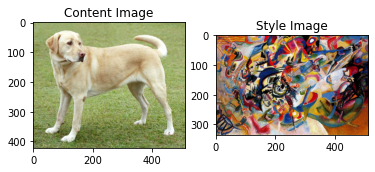

In [12]:
#시각화
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)  #1행 2열중 1번째
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)  #1행 2열중 2번째
imshow(style_image, 'Style Image')

### 전이학습 
-  훈련된 VGG 16 이용해서 학습 구조 이용
1. `tf.hub`: Style Transfer https://tfhub.dev/s?module-type=image-style-transfer
2. `tf.keras.applications`
- tensor 구조로 사용해서 prefetch 사용해서 cpu,gpu 자동 최적화
 > - NumPy API : Numpy를 GPU 사용 가능하도록 만듦
   - 참고: https://www.tensorflow.org/guide/tf_numpy?hl=ko


### 1.tf.hub

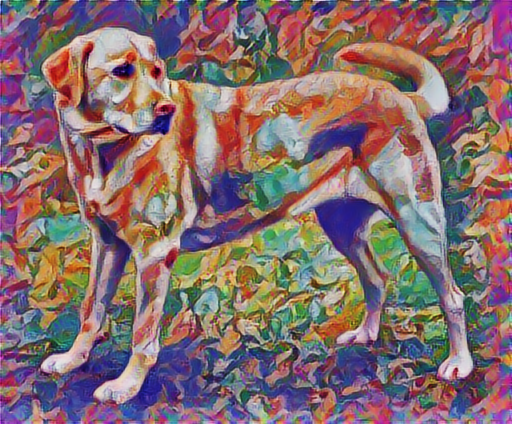

In [13]:
import tensorflow_hub as hub
# Style transfer 모델
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [14]:
content_path= tf.keras.utils.get_file('0e5f90af436e4c218343073164a5f657.JPG','https://t1.daumcdn.net/liveboard/holapet/0e5f90af436e4c218343073164a5f657.JPG')
content_image = load_img(content_path)
style_path= tf.keras.utils.get_file('The_Great_Wave_off_Kanagawa.jpg','https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg')
style_image = load_img(style_path)

2686976/2684586 [==============================] - 0s 0us/step


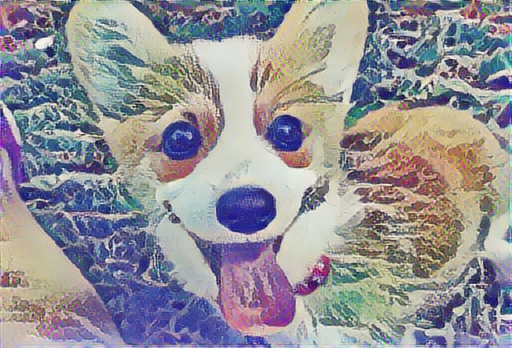

In [15]:
# Style transfer 모델
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [16]:
hub_module(tf.constant(content_image), tf.constant(style_image))[0].shape #0만 있음

TensorShape([1, 348, 512, 3])

### 2.keras.applications
- 학습된 vgg19 모델 작동 확인
  - FCNN 포함해서 Imagenet 학습된 가중치 가져옴

In [17]:
#원본 만드는 테크닉 
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # 255 곱해서 전처리 전 값 복원
x = tf.image.resize(x, (224, 224))                                  #resize: Imagenet 학습데이터 기반으로 학습되어 있어서 입력 데이터 크기 맞춤
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg.summary()

574717952/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [18]:
#모델 예측
prediction_probabilities = vgg(x)  #functional paradigm
prediction_probabilities.shape     #클래스 1000개의 예측값 

TensorShape([1, 1000])

In [19]:
np.all( vgg.predict(x) == vgg(x)) 

True

In [21]:
np.all( tf.equal( vgg.predict(x) , vgg(x)))

True

In [22]:
np.argmax(vgg(x)) #263번 값으로 가장 높게 예측 

263

In [23]:
#확률높은 5개
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(vgg(x).numpy())
predicted_top_5

40960/35363 [==================================] - 0s 0us/step


[[('n02113023', 'Pembroke', 0.94737804),
  ('n02113186', 'Cardigan', 0.05255118),
  ('n02105855', 'Shetland_sheepdog', 2.5088893e-05),
  ('n02106030', 'collie', 1.35653145e-05),
  ('n02086910', 'papillon', 5.356957e-06)]]

In [24]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(vgg(x).numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]  
#Pembroke 웰시 코기로 높은 정확도로 맞춤

[('Pembroke', 0.94737804),
 ('Cardigan', 0.05255118),
 ('Shetland_sheepdog', 2.5088893e-05),
 ('collie', 1.35653145e-05),
 ('papillon', 5.356957e-06)]

In [ ]:
#모델 이상없는것 확인하였으니 본격적으로 ..
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') #FCNN 제거  

print()  
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

- 이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간의 layer들을 선택해서 실험 비교
- 여러개의 layers 비교해서 가장 비슷한 것 선택
  > - 이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해, 모델의 몇 가지 중간층들을 살펴볼 것입니다.
   - 초반 레이어 : 선분,질감같은 저차원적 특성
   - 끝 레이어: 구체화된 고차원적 특성
> ZFnet: 레이어가 깊어질수록 추상화 정도가 높아짐

> - 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다. 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 **중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치**시키려고 시도할 것입니다.



In [ ]:
#레이어 선택
content_layers = ['block5_conv3']    
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv2'] 

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
#model fine tuning 
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False   # weight 보존해서 학습 안 시켜서 적용한 부분만 학습
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs) #multi-inputs 5, outputs
  return model

In [ ]:
vgg.input

<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>

In [ ]:
vgg.output

<tf.Tensor 'block5_pool/MaxPool_1:0' shape=(None, None, None, 512) dtype=float32>

---
- FCNN 제거
-  레이어 선택은 NFL: 모든 경우 따져봐서 결정

In [ ]:
vgg.weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
           -0.05099866, -0.00299793],
          [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
           -0.04020201,  0.04048637],
          [ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
           -0.03804016,  0.04690642]],
 
         [[ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
           -0.16508926, -0.06969624],
          [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
           -0.20492788, -0.0573062 ],
          [ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
           -0.19008617, -0.01889699]],
 
         [[-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
           -0.29905206, -0.2825364 ],
          [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
           -0.3915486 , -0.34632796],
          [-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562

In [ ]:
style_extractor = vgg_layers(style_layers)     #선택한 5 conv layers
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv2
  크기:  (1, 382, 512, 64)
  최솟값:  0.0
  최댓값:  3278.4497
  평균:  190.65747

block2_conv2
  크기:  (1, 191, 256, 128)
  최솟값:  0.0
  최댓값:  7240.0386
  평균:  210.92734

block3_conv2
  크기:  (1, 95, 128, 256)
  최솟값:  0.0
  최댓값:  10132.407
  평균:  285.92072

block4_conv2
  크기:  (1, 47, 64, 512)
  최솟값:  0.0
  최댓값:  24490.133
  평균:  589.7968

block5_conv2
  크기:  (1, 23, 32, 512)
  최솟값:  0.0
  최댓값:  1743.2627
  평균:  29.233082



### Gram matrix

> - 이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다. 이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 **상관관계** 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 
$G_{cd}= \frac{ \sum_{ij}F_{ijc}(x) F_{ijd}(x)}{IJ}$ 
  - `tf.linalg.einsum` : 행렬연산 표기법을 쉽게 구현 (numpy,pytorch,tf)
- 상관관계를 계산해서 비슷한 부분이 있어야 대체 


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # 4->3 차원 합
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

model 만드는법 5가지 

- tf.nn
- tf.estimator  -> keras 사용하는것을 추천
  - 쉽고 빠름
- keras: Sequential
- keras: model 
  - multi-inputs, outputs 
- keras: model subclassing


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers) # 레이어 초기화
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)             #5
    self.vgg.trainable = False                            # composition

  def call(self, inputs):                          #함수형 패러다임의 핵심
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],  
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)     #스타일 계산: 유사도 구함
                     for style_output in style_outputs]
    #레이어와 해당 값 관
    content_dict = {content_name:value  
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict} 

In [ ]:
tf.keras.applications.vgg16.VGG16( input_shape=None )# fcnn없으면 이미지 크기와 맞추지 않아도 상괎없음

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
extractor = StyleContentModel(style_layers, content_layers) #범용적

results = extractor(tf.constant(content_image))

# 통계량 비교 

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv2
    크기:  (1, 64, 64)
    최솟값:  20.160402
    최댓값:  212451.9
    평균:  4236.21

   block2_conv2
    크기:  (1, 128, 128)
    최솟값:  0.0018560849
    최댓값:  75678.15
    평균:  3287.0767

   block3_conv2
    크기:  (1, 256, 256)
    최솟값:  66.65243
    최댓값:  154295.19
    평균:  6739.726

   block4_conv2
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  807537.8
    평균:  21676.152

   block5_conv2
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  5058.728
    평균:  64.94978

콘텐츠:
   block5_conv3
    크기:  (1, 32, 32, 512)
    최솟값:  0.0
    최댓값:  432.83823
    평균:  3.1762261


### custom loss 
- multi-task:같은 모델에서 동시에 2가지 문제
  - 학습을 통해서 가장 유사한 부분이 있으면 가장 유사한 부분을 합성 시켜서 자연스럽게 보임.

In [ ]:
#target 지정
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
#최적화시킬 이미지를 담을 동일한 크기의 tf.Variable을 정의하고 콘텐츠 이미지로 초기화
image = tf.Variable(content_image)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
#전체 오차= content , style 의 가중합
style_weight=1e-2
content_weight=1e4

In [ ]:
#loss function 최소화하도록 update
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [ ]:
vgg.fit          #학습 == loss최소화 
tf.keras.losses#여기에 없으면 fit으로 학습 불가해서 만들어야함

<module 'tensorflow.keras.losses' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/losses/__init__.py'>

In [ ]:
a=np.array([1,2])
tf.add_n([a,a,a])#adds n input tensors element-wise.

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 6])>

In [ ]:
tf.add(a,a) #2개 tensors

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 4])>

### custom training 
-  다양한 gradient descent, activation 시도해서 multi-task loss 최소화 하려고 시도
  - 논문 :LBFGS 추천, 현재 Adam 충분
- CNN: feature extraction용도로 공유해서 사용해서 multi-tasking 잘 되는 경우도 있음 
-  multi-task loss에서도 trade-off 발생해서 graph 그려서 확인

  > imbalanced datasets :클래스 비유 조절 
    - 비율이 높은쪽으로 치중해서 학습
  > bias and variance trade-off 
loss 최소화 시키기 위해서 GradientTape 으로 함수를 backpropagtaion해서 자동미분으로 계산

### clipping
> - gradient vanishing - 값이 너무 작아져서 학습이 안 되는 현상
- gradient exploding - 값이 너무 커지는 문제 해결하는 방법
- gradient clipping으로 gradient를 0~1 사이로 잘라서 학습 문제 해결

In [ ]:
def clip_0_1(image): #clipping :값 0~1 사이만 존재하도록 값 자름
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
@tf.function() #decorator : 프로파일링으로 최적의 구조 구성
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)  #관련된 부분 같이 있음
    loss = style_content_loss(outputs) #loss

  grad = tape.gradient(loss, image)    #gradient
  opt.apply_gradients([(grad, image)]) #optimization
  image.assign(clip_0_1(image))        # gradient clipping

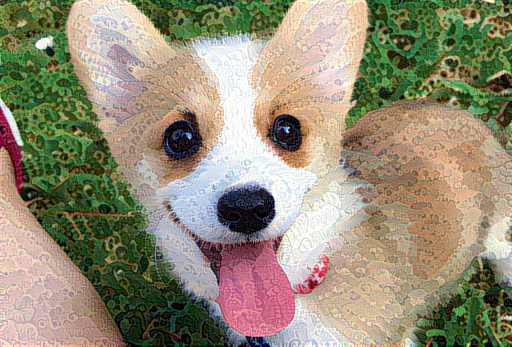

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image) 

#정답데이터가 없으므로 원하는 만큼 실행/ 레이러 변경해서 다시 재학습  

### tf.function
- TensorFlow 연산( python함수가 내부적으로 효율적 구조를 갖음) 가능한 속도를 높여서 최적화 
- 함수를 첫번째 인자로 받음
- immutable
  > - 성능을 높이고 이식성(portability)이 좋은 모델 ... 무조건 속도를 높여주는 마법은 은총알이 아닙니다.
  - 합성곱과 같은 계산량이 많은 연산에서는 속도 향상이 크지 않음.

- 디버깅 
  > 딥러닝은 디버깅이다.
  - 정답이 없으면 수정
  -  에러, profiling 성능 최적화  
- TF 2 속도를 보완 [효과적인 TF])https://www.tensorflow.org/guide/effective_tf2?hl=ko)
    > - JIT ( just in time ) 컴파일해서 최적화해서 속도 향상 
 > - Functional Pradigm 부수 효과(side effects)
   - 참고 :https://docs.python.org/3/howto/functional.html
  - input에 대한 output아 아닌경우 
  - coding에서 debugging을 위한 side effects
  - tf 1 static graph 속도 빠름 
    - compile 전체탐색해서 실행해서 속도 느림
    - 구성 다하고 compile 하고 계산 결과값이 바로 안 나왔었음
  - tf 2 dynamic graph 
   - eagerly executing (옵션에서 디폴트로 바꿈)
   - tf.executing_eagerly=True 즉시 결과 나오도록 바로 실행해서 속도가 느림 
   - 디버깅 용이 

- tf.funtion 성능 향상 참고: https://www.tensorflow.org/guide/function

In [ ]:
def x(a,b):
  return a+b

In [ ]:
x(3,4)            #7 
x([1,2,3],[4,5,6])#[1, 2, 3, 4, 5, 6]

[1, 2, 3, 4, 5, 6]

In [ ]:
@np.vectorize  #행렬처럼
def x(a,b):
  return a+b

In [ ]:
x([1,2,3],[4,5,6])#[5, 7, 9]

array([5, 7, 9])

In [ ]:
@tf.function   #tensor연산
def x(a,b):
  return a+b

In [ ]:
x(tf.constant([1,2,3]), tf.constant([1,2,3]) ) # tensor연산 가능

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 4, 6], dtype=int32)>

In [ ]:
x(np.arange(3), np.arange(3))  #tensor연산 가능

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 2, 4])>

- decorator() 테크닉
  - () 첫번째 인자 func만 def로 받아서 사용 , 다양한 옵션에 인자 입력 가능하며 
  - 인자를 여러개가 기본 디폴트 값으로 되어 있어서 에러 안남.

In [ ]:
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)  #관련된 부분 같이 있음
    loss = style_content_loss(outputs) #loss

  grad = tape.gradient(loss, image)    #gradient
  opt.apply_gradients([(grad, image)]) #optimization
  image.assign(clip_0_1(image))        # gradient clipping

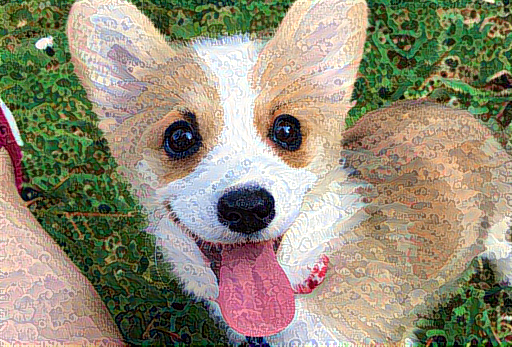

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image) 


In [ ]:
@tf.function #() 없는경우 : 작동 차이 없음  
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

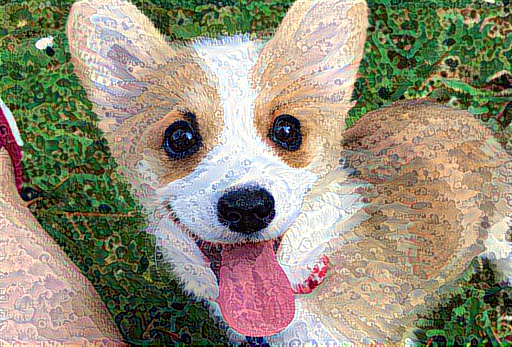

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image) 


- 계속 업데이트 되는 텐서플로우 학습 방법
 - major update 바뀔때 보는것을 추천
 - 하시는 일에 따라서 상이 
  - 가이드, 논문 구현 연습해서 도구를 적용
 - ! 신규 기법이여도 나중에 없어지기도 함

